In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

np.random.seed(42)


X, y = make_classification(
    n_samples=2000,
    n_features=30,
    n_informative=20,
    n_redundant=10,
    n_clusters_per_class=3,
    flip_y=0.15,
    class_sep=0.7,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## __Grid Search__

In [2]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", 0.5]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

start_time = time.time()
grid_search.fit(X_train, y_train)
grid_time = time.time() - start_time

Fitting 3 folds for each of 243 candidates, totalling 729 fits


## __Random Search__

In [3]:
param_dist  = {
    "n_estimators": randint(50, 300),
    "max_depth": [5, 10, 15, 20, 25, 30, None],
    "min_samples_split": randint(2, 15),
    "min_samples_leaf": randint(1, 10),
    "max_features": ["sqrt", "log2", 0.3, 0.5, 0.7],
    "bootstrap": [True, False]
}

random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_dist,
    n_iter=50,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

start_time = time.time()
random_search.fit(X_train, y_train)
random_time = time.time() - start_time

Fitting 3 folds for each of 50 candidates, totalling 150 fits


## __Results__

In [4]:
# Análisis de eficiencia
print(f"Efficiency Analysis")
print("-"*40)
print(f"Grid Search tried {len(grid_search.cv_results_["params"])} combinations")
print(f"Random Search tried {len(random_search.cv_results_["params"])} combinations")
print(f"Grid/Random Ratio: {len(grid_search.cv_results_["params"])/len(random_search.cv_results_["params"]):.1f}x")

print("\n\nGrid Search")
print("-"*40)
print(f"\t- Best Hiperparameters Combination: {grid_search.best_params_}")
print(f"\t- Best Accuracy: {grid_search.best_score_:.4f}")
print(f"\t- Search Time: {grid_time:.2f}s")

print("\nRandom Search")
print("-"*40)
print(f"\t- Best Hiperparameters Combination: {random_search.best_params_}")
print(f"\t- Best Accuracy: {random_search.best_score_:.4f}")
print(f"\t- Search Time: {random_time:.2f}s")

Efficiency Analysis
----------------------------------------
Grid Search tried 243 combinations
Random Search tried 50 combinations
Grid/Random Ratio: 4.9x


Grid Search
----------------------------------------
	- Best Hiperparameters Combination: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
	- Best Accuracy: 0.7436
	- Search Time: 78.99s

Random Search
----------------------------------------
	- Best Hiperparameters Combination: {'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 153}
	- Best Accuracy: 0.7371
	- Search Time: 33.24s


## __Improvement__

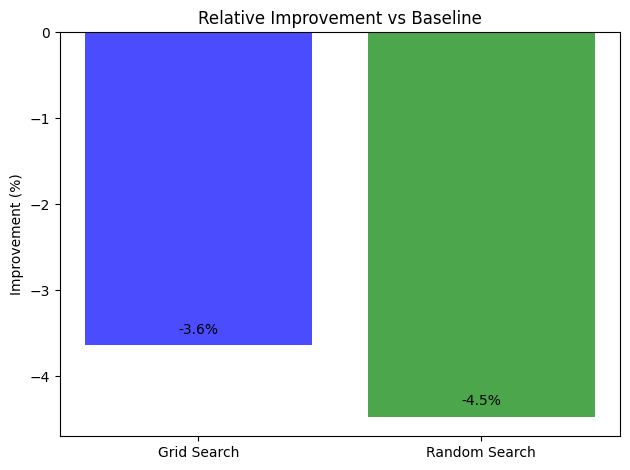

In [17]:
baseline_model = RandomForestClassifier(random_state=1939)
baseline_model.fit(X_train, y_train)
baseline_acc = baseline_model.score(X_test, y_test)

improvements = {
    "Grid Search": (grid_search.best_score_ - baseline_acc) / baseline_acc * 100,
    "Random Search": (random_search.best_score_ - baseline_acc) / baseline_acc * 100
}

methods_improvement = list(improvements.keys())
values_improvement = list(improvements.values())

bars = plt.bar(methods_improvement, values_improvement, color=["blue", "green"], alpha=0.7)
plt.title("Relative Improvement vs Baseline")
plt.ylabel("Improvement (%)")

for bar, imp in zip(bars, values_improvement):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f"{imp:.1f}%", ha="center", va="bottom")

plt.tight_layout()
plt.savefig("./figures/grid_random_comparison.png")
plt.show()